In [ ]:
# pip install factor_analyzer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda install -c conda-forge scikit-learn-extra

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

## Dataset Creation
The primary dataframe we will be working with is df_fct, which is a dataframe composed of only the 36 factor variables.

In [61]:
# Create dataframe from customer_data file
df = pd.read_csv('customer_data.csv')

# Create dataframe of factors only
df_fct =  df.drop(['UID','Const'], axis=1)

## Factor Analysis

The variables are all on a similar scale, so we will use the covariance matrix for identifying principal components.

In [21]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=len(df_fct.columns), rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
rotation = 'varimax'
n_factors = sum(i >= 1 for i in ev)
fa = FactorAnalyzer(n_factors=n_factors, rotation=rotation)

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,n_factors+1),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:n_factors],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:n_factors],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))
scores

,0,1,2,3,4,5,6,7
0,-0.320393,0.453115,-0.574211,-0.203965,-0.228620,0.192364,0.184343,0.247107
1,-0.201729,-0.552065,1.248292,0.657975,-0.780350,-0.233010,0.103988,0.012951
2,0.053185,0.407005,1.080822,0.443553,0.119964,0.360981,0.174121,-0.550133
3,-0.576393,-0.537746,-0.400512,0.295972,0.224316,-0.712317,0.503526,0.538692
4,0.215408,-0.005269,-0.956114,0.986772,-0.457368,0.359107,0.229643,0.104415
...,...,...,...,...,...,...,...,...
419,-1.042005,-0.975928,0.292017,0.077903,-1.884163,-0.672287,0.688665,0.477339
420,0.487004,-0.541245,-0.140340,0.784496,0.859532,2.039539,1.414266,-1.362369
421,0.393437,0.753155,0.331564,-0.091108,0.448870,-1.874029,-0.851719,0.514225
422,-0.068717,1.447157,1.108519,-0.360980,0.117049,-0.584465,0.425051,0.799894


### Clustering

In [64]:
sw=[]

for i in range (2,7):
    i_stats = []
    algorithm = "kMedoids"
    kMedoids = KMedoids(n_clusters=i, random_state=0)
    kMedoids.fit(scores)
    clusters=kMedoids.fit_predict(scores)
    silhouette_avg = silhouette_score(scores,clusters)  # 1 is a perfect score, -1 is worst score
    i_stats.append(algorithm)
    i_stats.append(i)
    i_stats.append(silhouette_avg)
    i_stats.append(clusters)
    sw.append(i_stats)
    print(f"{i} k-medoid clusters: {round(silhouette_avg,3)}")

for i in range (2,7):
    i_stats = []
    algorithm = "kMeans"
    kMeans = KMeans(n_clusters=i, random_state=0)
    kMeans.fit(scores)
    clusters=kMeans.labels_
    silhouette_avg = silhouette_score(scores,clusters)  # 1 is a perfect score, -1 is worst score
    i_stats.append(algorithm)
    i_stats.append(i)
    i_stats.append(silhouette_avg)
    i_stats.append(clusters)
    sw.append(i_stats)
    print(f"{i} k-means clusters: {round(silhouette_avg,3)}")
    
for i in range (2,7):
    i_stats = []
    algorithm = "hierarchical"
    hc = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage ='ward') #if linkage is ward, affinity must be Euclidean
    hc.fit_predict(scores)
    clusters=hc.labels_
    silhouette_avg = silhouette_score(scores,clusters)  # 1 is a perfect score, -1 is worst score
    i_stats.append(algorithm)
    i_stats.append(i)
    i_stats.append(silhouette_avg)
    i_stats.append(clusters)
    sw.append(i_stats)
    df_fct[algorithm+'_'+'cluster'+'_'+str(i)] = clusters
    print(f"{i} hierarchical clusters: {round(silhouette_avg,3)}")

# Reorder cluster lists by descending silhouette scores.  Clusters in first element should be assigned to training data.
sw = sorted(sw, key=itemgetter(2), reverse=True)

# Add the labels to the training dataset (you can ignore the warning when the cell runs)
df_fct['cluster'] = sw[0][3]  # Remember to change this back to 0 afterward

2 k-medoid clusters: 0.224
3 k-medoid clusters: 0.164
4 k-medoid clusters: 0.158
5 k-medoid clusters: 0.1
6 k-medoid clusters: 0.168
2 k-means clusters: 0.232
3 k-means clusters: 0.205
4 k-means clusters: 0.213
5 k-means clusters: 0.248
6 k-means clusters: 0.25


### Classification

In [52]:
clf_scores = []

# Split data into 80% training, 20% test
train, test = train_test_split(df_fct, test_size=0.2, random_state=123)

# X is unlabeled training data, y is true training labels 
X, y = train.loc[:, train.columns != 'cluster'], train['cluster']

X_test, y_test = test.loc[:, test.columns != 'cluster'], test['cluster']

#### Random Forest

In [53]:
alg = 'random_forest'

# Create the Random Forest object
clf = RandomForestClassifier(random_state=0)

# Fit the model to the training data
clf.fit(X,y)

# Score model
print(clf.score(X_test,y_test))

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

clf_scores.append(results)

0.788235294117647


##### RF Grid Search CV

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = len(df_fct), num = 10)]

# Number of features to consider at every split
max_features = ['sqrt', len(df_fct.columns)*0.1]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50, None],
 'max_features': ['sqrt', 3.7],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 136, 172, 208, 244, 280, 316, 352, 388, 424]}


In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=3, random_state=0, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [56]:
rf_random.best_params_

{'n_estimators': 352,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [57]:
best_random = rf_random.best_estimator_

best_random.score(X_test, y_test)

0.7647058823529411

#### Gradient Boosting

In [58]:
alg = 'gradient_boosting'

# Create the Random Forest object
clf = GradientBoostingClassifier(random_state=0)

# Fit the model to the training data
clf.fit(X,y)

# Score model
print(clf.score(X_test,y_test))

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

clf_scores.append(results)

0.7764705882352941


#### Support Vector Machine

In [59]:
from sklearn.svm import SVC

alg = 'support_vector_machine'

clf = SVC()
clf.fit(X, y)
clf.score(X_test,y_test)

results = []
results.append(alg)
results.append(clf.score(X_test,y_test))

clf_scores.append(results)

# Note, you can update the paramters like 
# model = SVC(C=10)
# model = SVC(gamma=100)
# from sklearn.svm import SVC
# model = SVC()

# model.fit(X_train, y_train)

# model.score(X_test,y_test)

# Note, you can update the paramters like 
# model = SVC(C=10)
# model = SVC(kernel='linear')

# Note: use Shift + Tab for the different options to pop up.

In [60]:
clf_scores = sorted(clf_scores, key=itemgetter(1), reverse=True)

clf_scores

[['support_vector_machine', 0.8705882352941177],
 ['random_forest', 0.788235294117647],
 ['gradient_boosting', 0.7764705882352941]]

#### Ensembling with VotingClassifier

In [137]:
from sklearn.ensemble import VotingClassifier

In [138]:
clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)

eclf = VotingClassifier(estimators=[('rf', clf1), ('gb', clf2)], voting='hard')
eclf = eclf.fit(X,y)

eclf_scores = eclf.score(X_test,y_test)

print("Mean Accuracy: ", round(eclf_scores*100,2), '%', sep='')

Mean Accuracy: 92.94%


**Next Steps**
* Is there an AutoML library for clustering/classification that we can use to autocluster and autoclassify
* Can we convert/bin all variable values to 1, 2, or 3 and then run the classification on that?
* If we look across rows, that will show an individual's preferences.  If we look down columns, that will show population preferences.
* Ensembling classifiers
* Adding and ensembling cluster algorithms
* Hyperparameter tuning on classifiers
* Meet with someone from NC State who can give some input

In [57]:
importance = pd.DataFrame(clf.feature_importances_)

<AxesSubplot:>

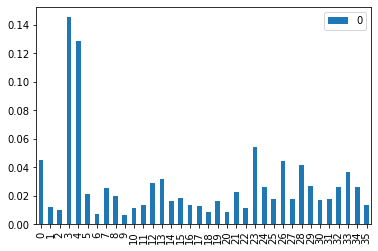

In [60]:
importance.plot(kind='bar')

## The Big Picture

Start with raw, unlabeled data - 400 data points in the population

Cluster and label all 400 data points

--- Some time passes, the clusters are evaluated.  Turns out, they are excellent!

--- New project comes along to assign clusters/personas to new customers

Split the original 400 classified data points and hold out 20% for evaluation

Create and evaluate classifiers (RF, Boost) based on the original 400 folks

### Other Ideas

Look for cluster evaluation

Tuning/looping through different factor analysis options

DBSCAN clustering algorithm
hierarchical clustering
k-fold cross-validation

Tuning classification algorithm



Instead of rotating the factors, we can just use the first 3 factors
Plot those 3 factors in 3 dimensions and view clusters

In [63]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=len(df_fct.columns), rotation=None)
fa.fit(df_fct)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

# Create FactorAnalyzer object
fa = FactorAnalyzer(n_factors=3, rotation=None)

# Fit factor analysis model to variables
fa.fit(df_fct)

# The loadings are the coefficients that make up the linear combination of original variables to get the factors (v1 = l1x1 + l2X2)
loadings = fa.loadings_

# Create dataframe of eigenvalues of the covariance matrix

data = {'factor'                    : range(1,4),
        'eigenvalues'               : fa.get_eigenvalues()[0][0:3],
        'common_factor_eigenvalues' : fa.get_eigenvalues()[1][0:3],
        'variance'                  : fa.get_factor_variance()[0],
        'proportional_variance'     : fa.get_factor_variance()[1],
        'cumulative_variance'       : fa.get_factor_variance()[2]
       }

cov_matrix_eigenvals = pd.DataFrame(data=data).set_index('factor')

# Scores for the factor analysis, converted to dataframe
scores = pd.DataFrame(fa.transform(df_fct))
scores

,0,1,2
0,-0.361479,0.511281,0.031665
1,0.084484,-1.051186,-0.091764
2,0.976740,0.029938,0.201850
3,-0.368205,-0.234792,-0.080435
4,0.038101,-0.307296,-0.062750
...,...,...,...
419,-1.388653,-0.942997,0.421107
420,1.599482,-0.421197,1.638810
421,0.122759,0.509517,-1.825720
422,0.822916,0.977341,-0.452744


In [66]:
scores['cluster'] = df_fct['cluster']
scores.head()

,0,1,2,cluster
0,-0.361479,0.511281,0.031665,3
1,0.084484,-1.051186,-0.091764,0
2,0.976740,0.029938,0.201850,1
3,-0.368205,-0.234792,-0.080435,3
4,0.038101,-0.307296,-0.062750,3


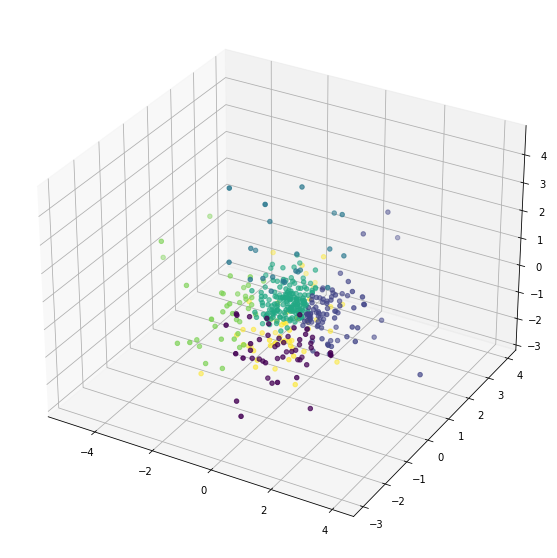

In [82]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(scores[0], scores[1], scores[2], c=scores['cluster'], marker='o')


# load some test data for demonstration and plot a wireframe
# ax.plot_wireframe(scores[0], scores[1], scores[2], rstride=5, cstride=5)

In [83]:
import plotly.express as px
fig = px.scatter_3d(scores, x=0, y=1, z=2, color='cluster')
fig.show()